**Task:** There are 2 cameras which capture the same scene from different positions. First camera is of depth type and the second one is rgb. The task is to find correspondence between pixels of deph image plane and rgb image plane with given calibration matrices for both cameras and extrinsics between two cameras.

In all code below calibration matrix is denoted as **K**, vector of distortion as **D**. Lower index **d** is for depth camera and **c**(color) for rgb. Extrinsics between two cameras are described with **R** - rotation matrix and **T** - translation vector (they define transformation from depth camera coordinate frame to rgb coordinate frame), $T_{opt}=\begin{bmatrix}R_{3\times 3} & t_{3 \times 1}\\0 &1\end{bmatrix}$ - is transformation matrix between corresponding coordinate systems.

**Solution** consists of four steps:

1. *Undistort calibration matrices and images using information about cameras distortions*
2. *Inverse persepective projection*: transform points from depth camera image frame to depth camera coordinate frame:  
  Direct perspective projection is described in step 4 (we only need to change subscripts from **c** to **d**).
  So, inverse projection looks like:
  
  $ \textbf x_d =  \begin{bmatrix}x_d \\y_d \\z_d\end{bmatrix} = \begin{bmatrix}
    f_x & 0 & o_x \\
    0 & f_y & o_y \\
    0 & 0 & 1  \\
    \end{bmatrix}^{-1} \begin{bmatrix}z_d u_d \\ z_d v_d \\ z_d\end{bmatrix} = K_d^{-1} z_d \begin{bmatrix} u_d \\ v_d \\ 1\end{bmatrix}$
    
   Where $\textbf x_d=\begin{bmatrix}x_d & y_d & z_d\end{bmatrix}^T$ is a coordinate of a point in depth camera coordinate frame ($z_d$ is corresponding depth) - these are given in millimeters. $\begin{bmatrix} u_d & v_d\end{bmatrix}$ is coordinate in depth camera image plane - these are given in pixels. $f_x, f_y, o_x, o_y$ are intrinsics parametrs: $(o_x, o_y)$ - is the principle point  and  $f_x, f_y$ - focal lengths in pixels. 
    
    
    
3. *Coordinate transformation*: change coordinate system from depth camera to rgb camera:  
    Firstly, we need to homogenize $\textbf x_d $ and then just multiply it with transformation matrix between corresponding coordinate systems to get $\textbf x_c=\begin{bmatrix}x_c & y_c & z_c\end{bmatrix}^T$ - coordinate of the same point of space in rgb camera coordinate system.
    
    $\begin{bmatrix}\textbf x_c  \\1 \end{bmatrix} = 
     \begin{bmatrix}x_c \\y_c \\z_c \\1 \end{bmatrix} =
      T_{opt}  \begin{bmatrix}\textbf x_d  \\1 \end{bmatrix}
      $

4. *Persepective projection*: transform point cloud from rgb camera coordinate frame to rgb camera image plane: 
   $\begin{bmatrix}u_c \\ v_c \\ 1\end{bmatrix} \equiv \mathrm{\{homogenous\, coordinates\}}\equiv 
      \begin{bmatrix}z_c u_c \\ z_c v_c \\ z_c\end{bmatrix} = 
    \left[
    \begin{array}{ccc|c}
    f_x & 0 & o_x & 0 \\
    0 & f_y & o_y & 0 \\
    0 & 0 & 1 & 0 \\
    \end{array}
    \right]
     \begin{bmatrix}x_c \\y_c \\z_c \\1 \end{bmatrix} =
      \begin{bmatrix}K_c \,\vert \,0\end{bmatrix}
      \begin{bmatrix}\textbf x_c  \\1 \end{bmatrix}$  
    Where $\textbf x_c=\begin{bmatrix}x_c & y_c & z_c\end{bmatrix}^T$ is coordinate of a point in rgb camera coordinate system ($z_c$ is corresponding depth) - these are given in millimeters. $\begin{bmatrix} u_c & v_c\end{bmatrix}$ is coordinate in rgb camera image plane - these are given in pixels. $f_x, f_y, o_x, o_y$ are intrinsics parametrs: $(o_x, o_y)$ - is the principle point  and  $f_x, f_y$ - focal lengths in pixels. 

In [112]:
import cv2
import numpy as np

from scipy.ndimage.filters import minimum_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os

In [36]:
############################### Depth camera parameters #############################################
#D - vector of distortion coefficients, K - calibration matrix
#d - index for depth

#Order: k1,k2,p1,p2,k3,k4,k5,k6
Dd = [5.268435, 3.562151, -0.000001, -0.000044,
      0.183290, 5.597448, 5.321101, 0.969790]
#Order: fx, _, ox, _, fy, oy, _, _
Kd = [503.958160, 0.0, 325.459106, 
      0.0, 504.007935, 340.334045,
      0.0, 0.0, 1.0]

Dd = np.array(Dd)
Kd = np.array(Kd).reshape((3, 3), order='C')

################################ RGB camera parameters ##############################################
#c - index for color
Dc = [0.694481, -2.708230, 0.001196, -0.000093,
      1.427999, 0.569216, -2.537520, 1.363558]

Kc = [611.050659, 0.0, 638.414490,
      0.0, 610.763855, 367.955139,
      0.0, 0.0, 1.0]


Dc = np.array(Dc)
Kc = np.array(Kc).reshape((3, 3), order='C')


############################### Extrinsics between cameras ##########################################
#Rotation
R = np.array([[1, -0.000781557, 0.000539185],
             [0.000727472, 0.995581, 0.0939047],
             [-0.000610194, -0.0939042, 0.995581]])

#Translation
T = np.array([-32.0128, -2.1236, 3.94259])


T_opt = np.hstack((R, T[:, None]))
T_opt = np.vstack((T_opt, np.array([[0, 0, 0, 1]])))
T_opt

array([[ 1.00000e+00, -7.81557e-04,  5.39185e-04, -3.20128e+01],
       [ 7.27472e-04,  9.95581e-01,  9.39047e-02, -2.12360e+00],
       [-6.10194e-04, -9.39042e-02,  9.95581e-01,  3.94259e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]])

In [113]:
def rotate180(img):
    return cv2.rotate(img,  cv2.ROTATE_180)

In [155]:
#Get corresponding color, ir and depth images

img_depth = cv2.imread('OUTPUT_DIR/2022-02-24-10-26-13/1m/depth/4049.834.png', cv2.IMREAD_UNCHANGED)
img_rgb = plt.imread('OUTPUT_DIR/2022-02-24-10-26-13/1m/color/4049.856.png')

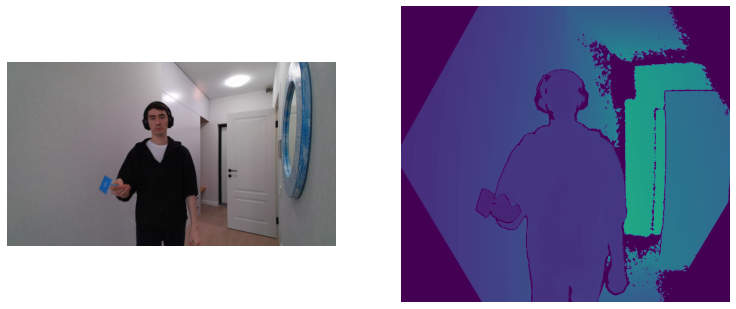

In [156]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(132)
plt.imshow(img_depth)
plt.axis("off");

### 1.1 Undistort intrinsics

In [157]:
def undistort_calibration_matrix(shape, calibration_matrix, dist_coeff):
    """
    Returns undistorted calibration matrix.
    
    : param shape : shape of image [x, y]
    : param calibration_matrix : calibration matrix [3 x 3]
    : param dist_coeff : distortions' vector
    """
    undist_calibration, _ = cv2.getOptimalNewCameraMatrix(calibration_matrix, dist_coeff, shape, 1, shape)

    return undist_calibration

In [158]:
Kc_undistorted = undistort_calibration_matrix(img_rgb.shape[:2], Kc, Dc)
Kd_undistorted = undistort_calibration_matrix(img_depth.shape, Kd, Dd)

### 1.2 Undistort images

In [159]:
def undistort_image(image, calibration_matrix, dist_coeff, undist_calibration_matrix, inter_method):
    """
    Returns undistorted image.
    
    : param image : image to undistort
    : param calibration_matrix : calibration matrix [3 x 3]
    : param dist_coeff : distortions' vector
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    : param inter_method : method of interpolation
    """
    if len(image.shape) == 3:
        shape = image.shape[::-1][1:]

    elif len(image.shape) == 2:
        shape = image.shape[::-1]

    else:
        raise NotImplementedError

    map_x, map_y = cv2.initUndistortRectifyMap(calibration_matrix, dist_coeff, None, undist_calibration_matrix, shape, cv2.CV_32FC1)
    undist_image = cv2.remap(image, map_x, map_y, inter_method)

    return undist_image

In [160]:
img_rgb_undistorted = undistort_image(img_rgb, Kc, Dc, Kc_undistorted, cv2.INTER_LINEAR)
img_depth_undistorted = undistort_image(img_depth, Kd, Dd, Kd_undistorted, cv2.INTER_LINEAR)

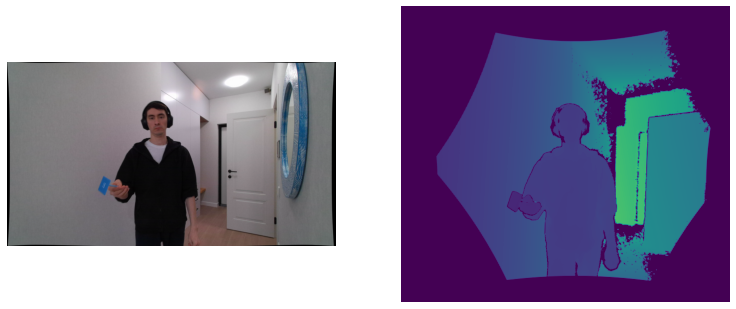

In [161]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(img_rgb_undistorted)
plt.axis("off")

plt.subplot(132)
plt.imshow(img_depth_undistorted)
plt.axis("off");

###  2 From image plane to local coordinate frame of depth camera

In [162]:
def to_homogeneous(t):
    """
    Homegenize coordinates.
    
    : param t : cartesian coordinates
    """
    return np.concatenate((t, np.ones((len(t), 1))), axis=-1)


def to_norm_image_coord(loc_kp, calibration_matrix):
    """
    : param loc_kp : np.ndarray(N, 2), points to transform
    : param calibration_matrix : calibration matrix [3 x 3]
    """
    return (np.linalg.inv(calibration_matrix) @ to_homogeneous(loc_kp).T).T


def pointcloudify_depths(img_depth, undist_calibration_matrix):
    """
    Transform from depth image frame to depth camera frame.
    
    : param img_depth : np.ndarray, depth image
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    """
    shape = img_depth.shape[::-1]

    grid_x, grid_y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    grid = np.concatenate([np.expand_dims(grid_x, -1),
                           np.expand_dims(grid_y, -1)], axis=-1)

    norm_grid = to_norm_image_coord(grid.reshape(-1, 2), undist_calibration_matrix)

    # Raise by undistorted depth value from image plane to local camera space 
    local_grid = norm_grid * np.expand_dims(img_depth.reshape(-1), axis=-1)


    return local_grid.astype(np.float32)

In [163]:
local_depth_camera_pcd = pointcloudify_depths(img_depth_undistorted, Kd_undistorted)

###  3 From coordinate system of depth camera to coordinate system of rgb camera

In [80]:
def to_cartesian(t):
    """
    Dehomegenize coordinates.
    
    : param t : homogeneous coordinates
    """
    return t[:, :-1] / np.expand_dims(t[:, -1], -1)

In [170]:
local_rgb_camera_pcd = to_cartesian((T_opt @ to_homogeneous(local_depth_camera_pcd).transpose()).transpose())

### 4  Transform point cloud from rgb camera coordinate frame to rgb camera image plane and plot projected points

In [96]:
def project2image(scene_points, undistorted_calibration_matrix):
    """
    Transform point cloud from camera coordinate frame to camera image plane.
    
    : param scene_points : np.ndarray(N, 3), point cloud in camera coordinate frame
    """
    return to_cartesian((undistorted_calibration_matrix @ scene_points.T).T)


def plot_projected_pcd(image, local_scene_points, undist_calibration_matrix, key, fig_size=(18, 18), path_to_save=''):
    """
    Highlight pixels which have correspondences both in depth and rgb images and plot them over rgb image.
    
    : param image : rgb image on which to project
    : param local_scene_points : np.ndarray(N, 3), point cloud in rgb camera coordinate frame
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    : param key : key of image (used as title)
    : param path_to_save : path to save figure, if given only save figure without showing it
    
    """
    h, w = image.shape[:2]

    d = np.linalg.norm(local_scene_points, axis=-1)

    proj_pcd = project2image(local_scene_points, undist_calibration_matrix)
    proj_pcd = np.round(proj_pcd).astype(int)[:, [0, 1]]

    proj_mask = (proj_pcd[:, 0] >= 0) & (proj_pcd[:, 0] < w) & (proj_pcd[:, 1] >= 0) & (proj_pcd[:, 1] < h)

    proj_pcd = proj_pcd[proj_mask, :]
    d = d[proj_mask]

    max_value = d.max() * 2

    pcd_image = np.ones((h, w)) * max_value

    pcd_image[proj_pcd[:, 1], proj_pcd[:, 0]] = d
    pcd_image = minimum_filter(pcd_image, footprint=np.ones((5, 5)))
    pcd_image[pcd_image == max_value] = 0.0

    normalize = mcolors.Normalize(vmin=np.min(pcd_image), vmax=np.max(pcd_image))
    s_map = cm.ScalarMappable(norm=normalize, cmap=cm.viridis)

    pcd_image_rgba = s_map.to_rgba(pcd_image) * (1 - np.expand_dims(pcd_image == 0.0, -1))
    
    plt.figure(figsize=fig_size)
    plt.title(key)
    plt.imshow(image)
    plt.imshow(pcd_image_rgba, alpha=0.3)
    if path_to_save:
        plt.savefig(path_to_save)
        plt.close()

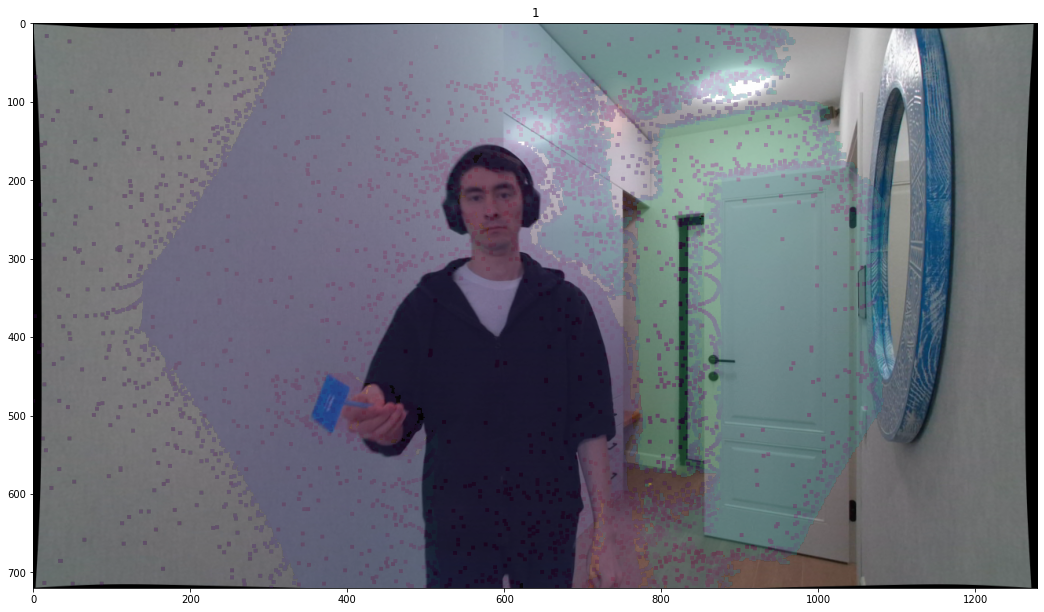

In [171]:
plot_projected_pcd(img_rgb_undistorted, local_rgb_camera_pcd, Kc_undistorted, key=1)

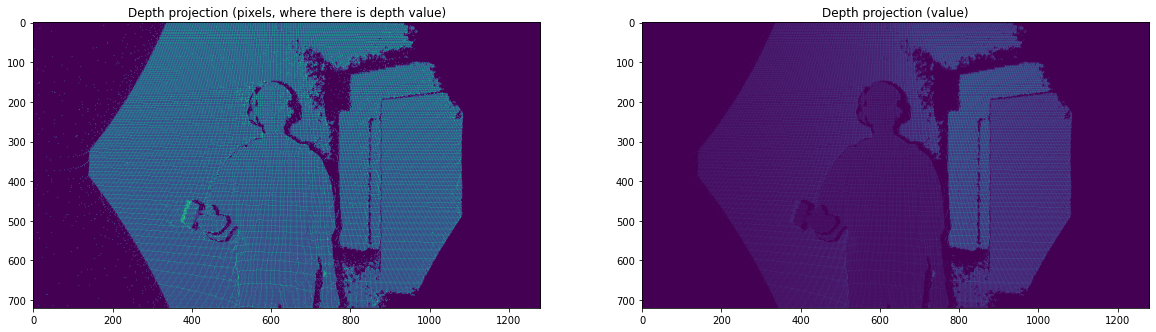

In [166]:
image = img_rgb_undistorted
local_scene_points = local_rgb_camera_pcd
undist_intrinsics = Kc_undistorted
key = 1
fig_size=(18, 18)


h, w = image.shape[:2]

depth = local_scene_points[:, 2]
proj_pcd = project2image(local_scene_points, undist_intrinsics)

proj_pcd = np.round(proj_pcd).astype(int)[:, [0, 1]]
proj_mask = (proj_pcd[:, 0] >= 0) & (proj_pcd[:, 0] < w) & (proj_pcd[:, 1] >= 0) & (proj_pcd[:, 1] < h)

proj_pcd = proj_pcd[proj_mask, :]
depth = depth[proj_mask]


pcd_image = np.zeros((h, w))
pcd_image[proj_pcd[:, 1], proj_pcd[:, 0]] = depth


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(pcd_image > 0)
plt.title('Depth projection (pixels, where there is depth value)')

plt.subplot(122)
plt.imshow(pcd_image)
plt.title('Depth projection (value)');

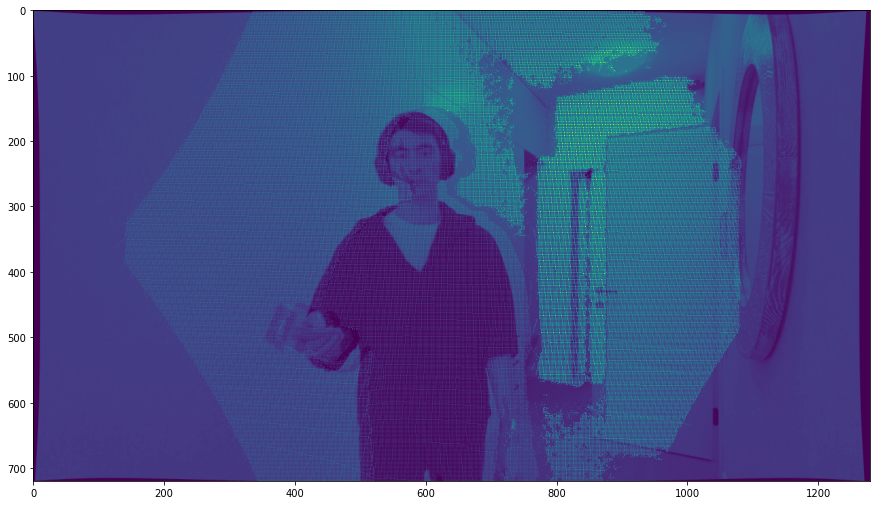

In [167]:
from skimage.color import rgb2gray

scaler = lambda x: (x - x.min()) / (x.max() - x.min())

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(0.3 * rgb2gray(image) + 0.7 * scaler(pcd_image))

# All pipeline

In [100]:
import os

def images_names_alignment(output_dir):
    
    rgb_to_depth_names_corresp = {} 
    
    path_to_rgb_images = os.listdir(output_dir + 'color/')
    path_to_depth_images = os.listdir(output_dir + 'depth/')
    
    rgb_format = path_to_rgb_images[0].rsplit('.', 1)[1]
    depth_format = path_to_depth_images[0].rsplit('.', 1)[1]
    
    rgb_timestamps = np.array([float(path.rsplit('.', 1)[0]) for path in path_to_rgb_images])
    depth_timestamps = np.array([float(path.rsplit('.', 1)[0]) for path in path_to_depth_images])
    
    for ts in rgb_timestamps:
        cor_idx = np.argmin(np.abs(ts - depth_timestamps))
        rgb_to_depth_names_corresp[f'{ts}.{rgb_format}'] = f'{depth_timestamps[cor_idx]}.{depth_format}'
    
    return rgb_to_depth_names_corresp

In [109]:
def depth2rgb(output_dir, Kc, Kd, Dc, Dd):

    rgb_to_depth_names_corresp = images_names_alignment(output_dir)
    
    path_to_rgb_dir = output_dir + 'color/'
    path_to_depth_dir = output_dir + 'depth/'
    
    for rgb_path, depth_path in rgb_to_depth_names_corresp.items():
        
        img_depth = cv2.imread(path_to_depth_dir + depth_path, cv2.IMREAD_UNCHANGED)
        img_rgb = plt.imread(path_to_rgb_dir + rgb_path)

        Kc_undistorted = undistort_calibration_matrix(img_rgb.shape[:2], Kc, Dc)
        Kd_undistorted = undistort_calibration_matrix(img_depth.shape, Kd, Dd)
        
        img_rgb_undistorted = undistort_image(img_rgb, Kc, Dc, Kc_undistorted, cv2.INTER_LINEAR)
        img_depth_undistorted = undistort_image(img_depth, Kd, Dd, Kd_undistorted, cv2.INTER_LINEAR)
        
        local_depth_camera_pcd = pointcloudify_depths(img_depth_undistorted, Kd_undistorted)
        local_rgb_camera_pcd = to_cartesian((T_opt @ to_homogeneous(local_depth_camera_pcd).transpose()).transpose())
        
        plot_projected_pcd(img_rgb_undistorted, local_rgb_camera_pcd, Kc_undistorted, key=rgb_path, path_to_save=output_dir + 'aligned/'+ rgb_path)

In [110]:
depth2rgb('OUTPUT_DIR/2022-02-24-10-26-13/1m/', Kc, Kd, Dc, Dd)